In [1]:
import cv2 as cv
import numpy as np
import torch
import random

from models.common import DetectMultiBackend
from matplotlib import pyplot as plt
from utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_coords
from utils.plots import Annotator, colors
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda:0")
model = DetectMultiBackend("yolov5s6.pt", device=device)
detect = model.model.model[-1]
names = model.model.names
labels = names
num_anchors = len(detect.anchors)
anchors = [detect.anchor_grid[i][0,:,0,0].cpu().numpy().tolist() for i in range(num_anchors)]

Fusing layers... 
YOLOv5s6 summary: 280 layers, 12612508 parameters, 0 gradients, 16.8 GFLOPs


(1080, 810, 3)


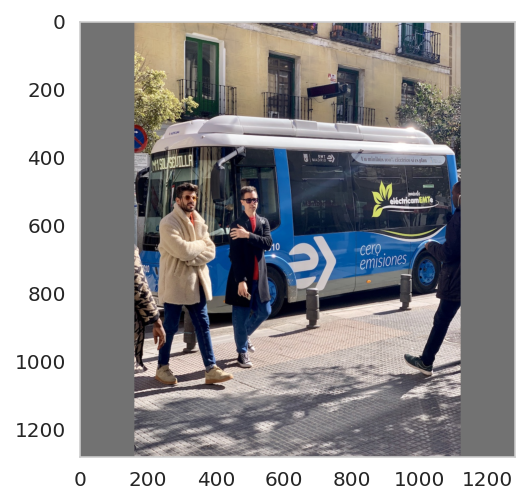

In [3]:
img = cv.imread("data/images/bus.jpg")
img0 = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# im0 = cv.resize(img0, (1280, 1280))
im0 = letterbox(img0, new_shape=(1280, 1280), stride=32, auto=False)[0]
print(img.shape)

def plot_single_image(image, grid=0, call=False):
    plt.grid(grid)
    plt.imshow(image)
    if not call:
        plt.show()

def plot_multi_images(*images, grid=0):
    n = len(images)
    assert n, "Func needs at least 2 image as param!"
    row_colum = 100 + n * 10
    plt.figure(figsize=(5*n, 8),dpi=60)
    for i, image in enumerate(images):
        plt.subplot(row_colum + i + 1)
        plot_single_image(image, grid=grid, call=True)
    plt.show()

# plot_multi_images(img0, im0)
plot_single_image(im0)

In [4]:
im = np.expand_dims(im0.transpose(2,0,1), 0) / 255.0
batch_in = torch.Tensor(im).to(device).float()
out, train_out = model(batch_in, augment=False, val=True)

In [5]:
pred = non_max_suppression(out, 0.4, 0.45)

Detect:
[0, 552, 78, 880] ind0:person 64.32
[22, 220, 802, 750] ind5:bus 85.38
[53, 398, 248, 899] ind0:person 88.84
[224, 414, 346, 858] ind0:person 90.22
[662, 399, 810, 879] ind0:person 93.12


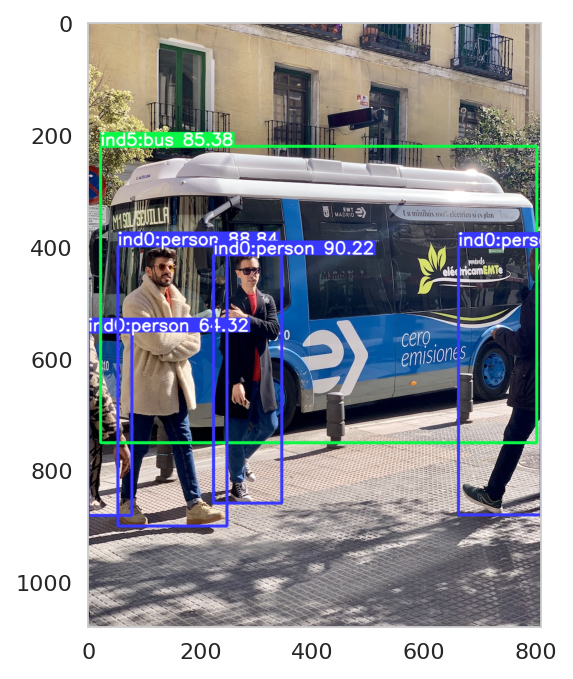

In [6]:
def plot_detect_src(prediction, batch_inputs, img_source, title=None):
    det = torch.ones_like(prediction[0], device=device)
    det.copy_(prediction[0])
    det[:, :4] = scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
    annotator = Annotator(img_source.copy())
    for *xyxy, conf, cls in reversed(det):
        c = int(cls)
        label = f'ind{c}:{labels[c]} {conf*100:.2f}'
        print([int(i.cpu().numpy()) for i in xyxy], label)
        annotator.box_label(xyxy, label, color=colors(c, True))
    detect_img = annotator.result()
    plt.figure(figsize=(5, 5), dpi=80)
    if title is not None:
        plt.title(title)
    plot_single_image(detect_img)
print("Detect:")
plot_detect_src(pred, batch_in, img0)

In [7]:
nb, channels, height, width = batch_in.shape # number of batches, channels, HW
nl = len(anchors)  # number of detection layers:4
na = len(anchors[0])  #number of anchors per head
nc = len(labels)
#out_shape : [batch, sum(n * grid_size ** 2) of each head, no]
print("Out:", out.shape)
no = out.shape[2] # Num of Classes + 5 : XYWH, Confidence
assert nc == out.shape[2]-5, f'Number of Classes({nc}) Does NOT Match with output size!'

detect_grid_size = [20 * 2 ** i for i in range(nl)]
detect_grid_size.reverse()
slice_size = [i ** 2 * na for i in detect_grid_size]

print(f"Head:{nl}", f"Anchors:{na}", f"Number of Classes:{nc}")
print("Grid size:", detect_grid_size)
print("Slice size:", slice_size, " -> Sum =", sum(slice_size))
print("Output size", out.shape[1])
assert sum(slice_size) == out.shape[1]

Out: torch.Size([1, 102000, 85])
Head:4 Anchors:3 Number of Classes:80
Grid size: [160, 80, 40, 20]
Slice size: [76800, 19200, 4800, 1200]  -> Sum = 102000
Output size 102000


In [8]:
slice_index = [0]
for i in slice_size:
    slice_index.append(i + slice_index[-1])
print(slice_index)
head = []
for i in range(len(slice_index) - 1):
    layer = out[:, slice_index[i]:slice_index[i+1], :].squeeze()
    new_shape = [na, detect_grid_size[i], detect_grid_size[i], no]
    print(layer.shape[:], "-->", new_shape)
    layer = layer.reshape(new_shape)
    head.append(layer.permute(0, 3, 1, 2))
print(len(head), "Heads:", *(i.shape for i in head))

[0, 76800, 96000, 100800, 102000]
torch.Size([76800, 85]) --> [3, 160, 160, 85]
torch.Size([19200, 85]) --> [3, 80, 80, 85]
torch.Size([4800, 85]) --> [3, 40, 40, 85]
torch.Size([1200, 85]) --> [3, 20, 20, 85]
4 Heads: torch.Size([3, 85, 160, 160]) torch.Size([3, 85, 80, 80]) torch.Size([3, 85, 40, 40]) torch.Size([3, 85, 20, 20])


Batch_in & Head[3][0,4]:Conf

[161, 655, 252, 1043] ind0:person 64.32
[187, 261, 1110, 888] ind5:bus 85.38
[222, 472, 454, 1065] ind0:person 88.84
[426, 490, 570, 1017] ind0:person 90.22
[945, 473, 1120, 1041] ind0:person 93.12


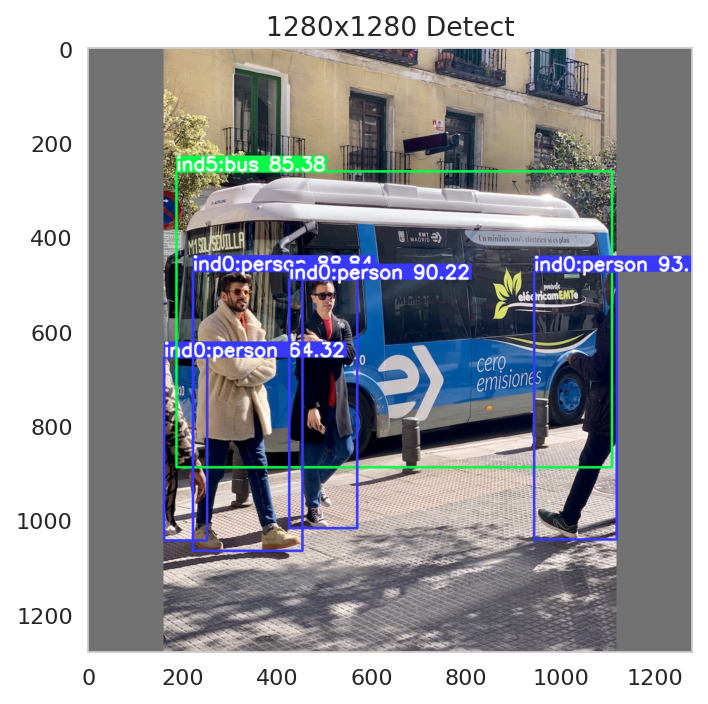

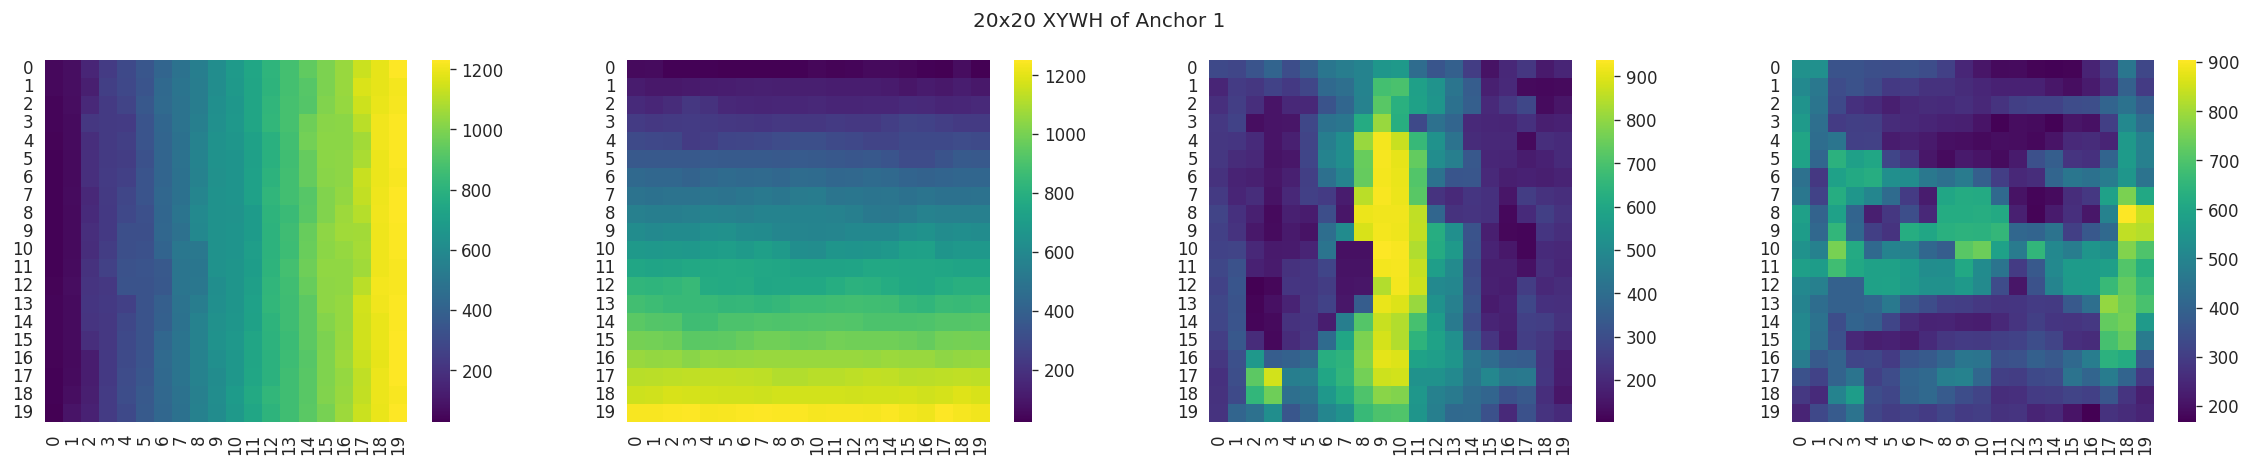

In [9]:
def plot_single_heatmap(array, cmap='viridis', title=None, dpi=60):
    plt.figure(figsize=(5, 5), dpi=dpi)
    if title:
        plt.title(title)
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()
    sns.heatmap(array, square=True, cmap=cmap)


def plot_multi_heatmap(*arrays, cmap='viridis', title=None, row=None, col=None):
    n = len(arrays)
    if row is not None:
        col = int(np.ceil(n / row))
    else:
        if col is not None:
            row = int(np.ceil(n / col))
        else:
            row = int(np.sqrt(n))
            col = int(np.ceil(n / row))

    fig, ax = plt.subplots(row, col, figsize=(6*col, 4*row), dpi = 60)
    if title is not None: fig.suptitle(title)

    for i, array in enumerate(arrays):
        if isinstance(array, torch.Tensor):
            array = array.cpu().numpy()
        r = i // col
        c = i % col
        axi = ax[r, c] if row > 1 else ax[c]
        sns.heatmap(array, square=True, cmap=cmap, ax=axi)
    plt.show()

print("Batch_in & Head[3][0,4]:Conf\n")
plot_detect_src(pred, batch_in, im0, title="1280x1280 Detect")
plot_multi_heatmap(*(head[3][0,i] for i in range(4)), row=1, title="20x20 XYWH of Anchor 1")

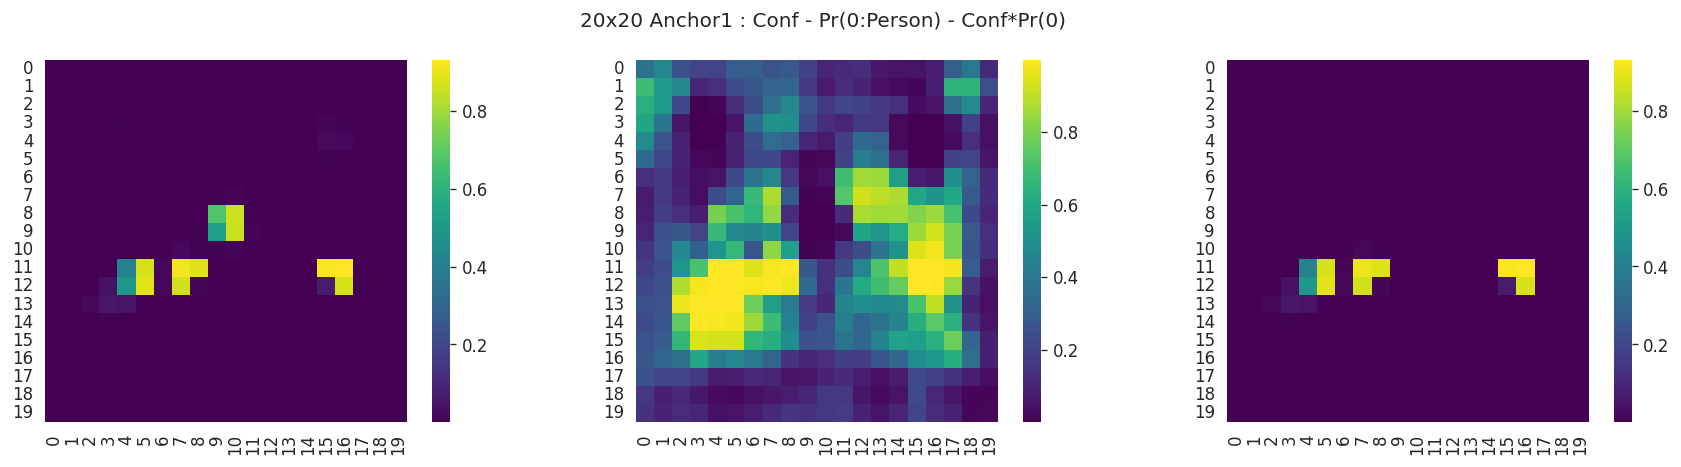

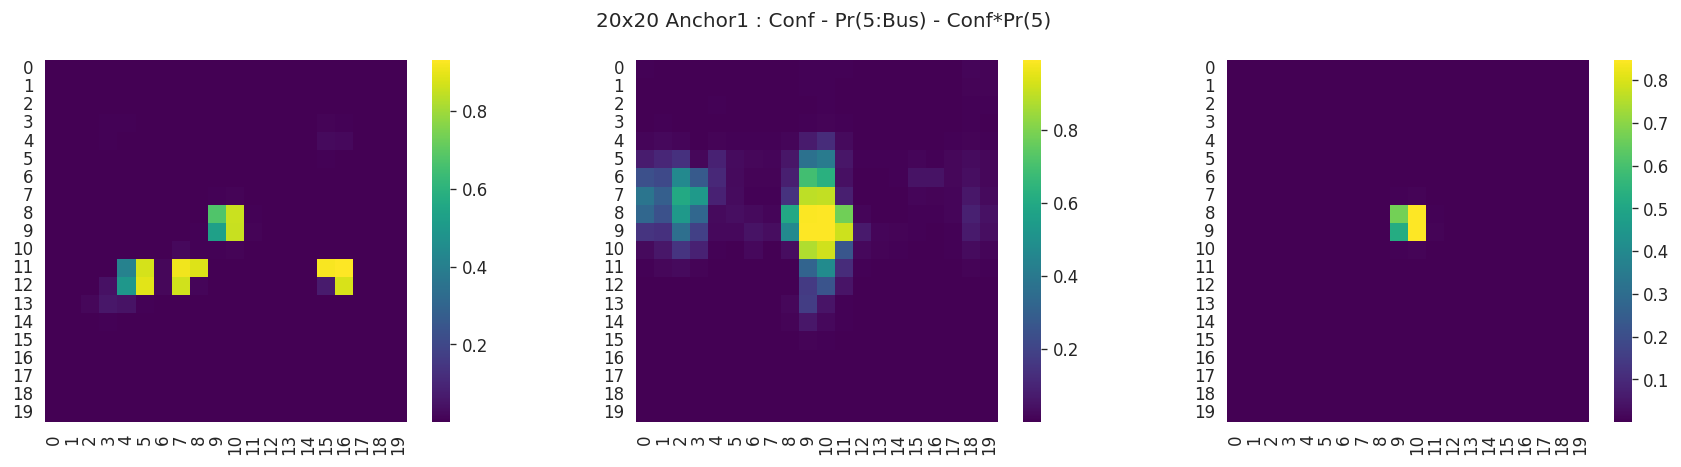

In [10]:
conf = head[3][0,4]
classes_confidence = head[3][0,5:] * conf
# plot_single_heatmap(head[3][0,5], title="Ind0:Person Conf of Anchor 1")      # Conf(0)
# plot_single_heatmap(classes_confidence[0], title="Ind0:Pr(Person) * Conf") #Pr(obj) * Conf(0)
plot_multi_heatmap(conf, head[3][0,5], classes_confidence[0], title="20x20 Anchor1 : Conf - Pr(0:Person) - Conf*Pr(0)")
plot_multi_heatmap(conf, head[3][0,10], classes_confidence[5], title="20x20 Anchor1 : Conf - Pr(5:Bus) - Conf*Pr(5)")
del classes_confidence

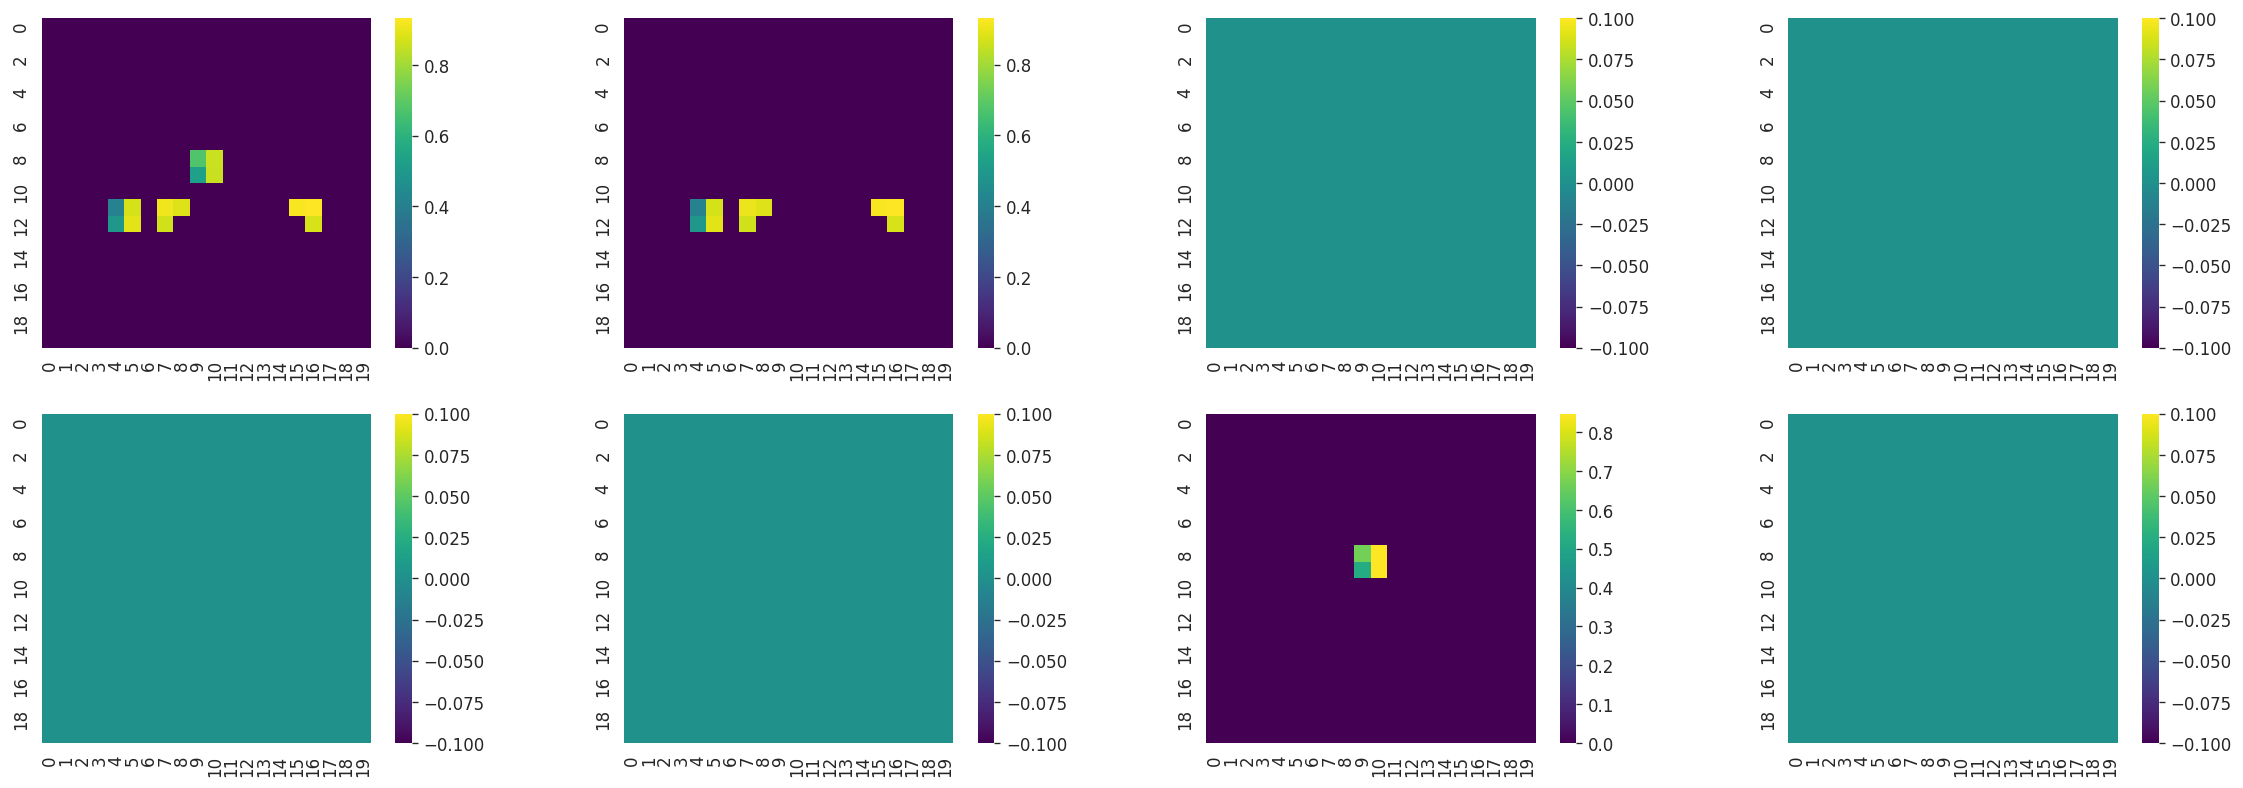

In [11]:
conf_threshold = 0.3
iou_threshold = 0.6
pr_filt = torch.where(conf < conf_threshold, 0, head[3][0, ...])
pr_filt[pr_filt < 0.01] = 0
pr_filt[5:] *= conf
names = list("XYWHC") + labels
plot_multi_heatmap(*(pr_filt[i] for i in range(4,12)))

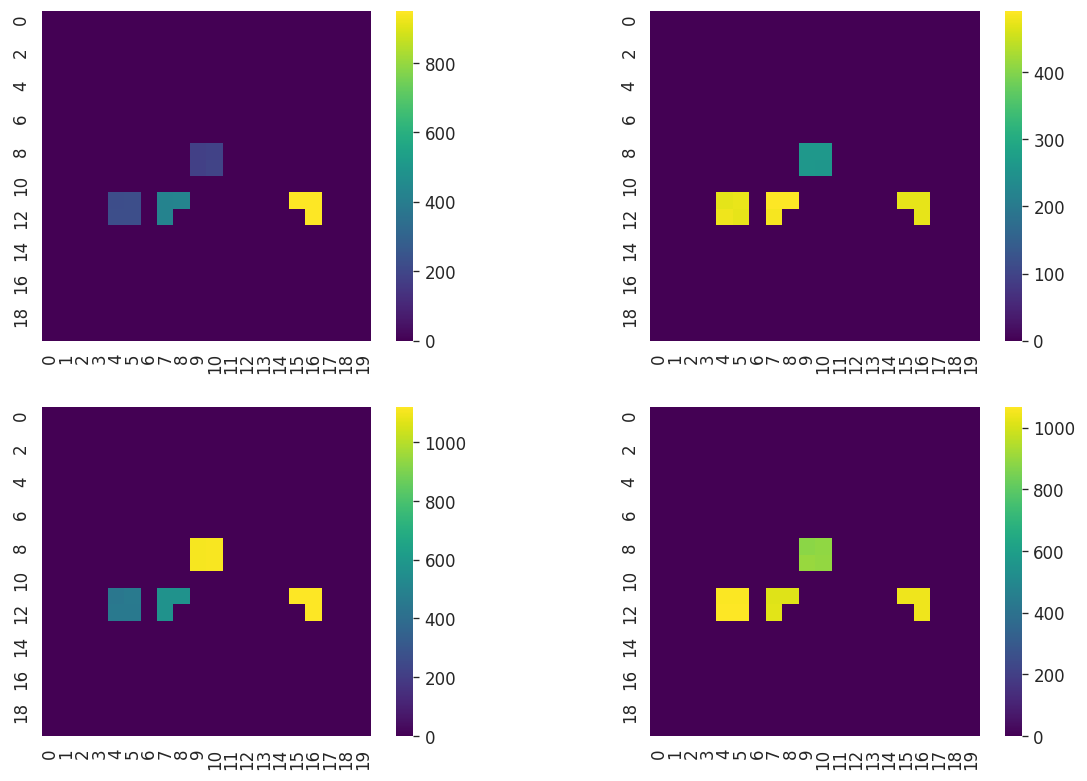

In [12]:
box = pr_filt[:4, ...]
def xywh2xyxy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[0:, ...] = x[0, ...] - x[2, ...] / 2 # top left x
    y[1:, ...] = x[1, ...] - x[3, ...] / 2 # top left y
    y[2:, ...] = x[0, ...] + x[2, ...] / 2 # bottom right x
    y[3:, ...] = x[1, ...] + x[3, ...] / 2 # bottom right y
    return y
box = xywh2xyxy(box)
plot_multi_heatmap(*(box[i] for i in range(4)))

In [13]:
d1, d2 = torch.where(pr_filt[5] > conf_threshold)
d1 = list(d1.cpu().numpy())
d2 = list(d2.cpu().numpy())
yx = list(zip(d1,d2))

In [14]:
yx.sort(key=lambda vec: pr_filt[5,vec[0],vec[1]], reverse=True)
p1p2 = []
for y, x in yx:
    print(y, x, f"{float(pr_filt[5, y, x]):.2f}", sep="\t", end="\t")
    xyxy = np.append(box[..., y, x].cpu(), 0)
    xyxy = np.append(xyxy, pr_filt[5, y, x].cpu())
    print(xyxy)
    p1p2.append((xyxy))

xyxy = np.concatenate(p1p2, axis=0).reshape(-1, 6)

11	16	0.93	[     945.16      472.55      1120.2      1041.2           0     0.93123]
11	15	0.92	[      944.9      471.24        1118      1040.7           0     0.92086]
11	7	0.90	[     425.92      490.11      569.85        1017           0     0.90225]
12	5	0.89	[     222.44      472.13      453.55      1064.9           0     0.88843]
11	8	0.88	[     427.61      488.21      571.15      1016.7           0     0.88242]
12	16	0.87	[     948.29      472.29      1118.9      1040.3           0     0.87419]
11	5	0.87	[     223.37      473.16      455.82      1062.9           0      0.8722]
12	7	0.86	[     424.22      483.79       570.3      1020.6           0     0.86435]
12	4	0.49	[     222.56      478.37      453.53      1067.7           0     0.49199]
11	4	0.41	[     221.39      470.41      444.98      1059.6           0     0.40779]


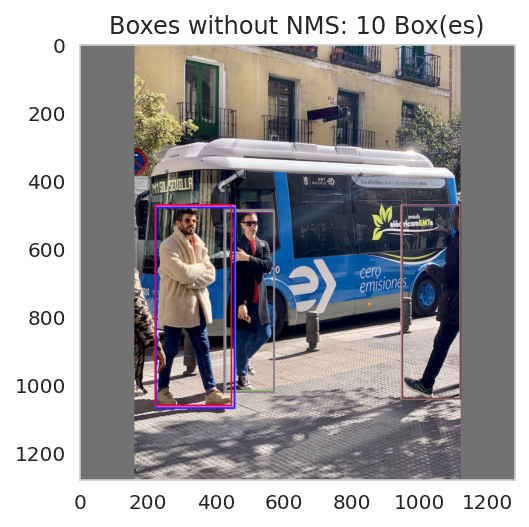

In [15]:
im1 = im0.copy()

for x1, y1, x2, y2 in xyxy.round().astype(np.uint16)[..., :4]:
    cv.rectangle(im1, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)

plt.title(f"Boxes without NMS: {xyxy.shape[0]} Box(es)")
plot_single_image(im1)

In [16]:
def compute_area(x1y1x2y2):
    x1, y1, x2, y2 = x1y1x2y2.astype(np.float64)[:4]
    return (x2 - x1) * (y2 - y1)

def compute_intersection(xa1, xa2, xb1, xb2):
    assert xa1 <= xa2 and xb1 <= xb2, "x1 must <= x2"
    if xa1 > xb1:
        return compute_intersection(xb1, xb2, xa1, xa2)
    return min(max(xa2 - xb1, 0), xb2 - xb1)

def compute_iou(xyxy1, xyxy2):
    area_1, area_2 = compute_area(xyxy1), compute_area(xyxy2)
    x11, y11, x12, y12 = xyxy1.astype(np.float64)[:4]
    x21, y21, x22, y22 = xyxy2.astype(np.float64)[:4]

    x_in = compute_intersection(x11, x12, x21, x22)
    y_in = compute_intersection(y11, y12, y21, y22)
    area_intersection = x_in * y_in

    return area_intersection / (area_1 + area_2 - area_intersection)

def compute_diou(xyxy1, xyxy2):
    x11, y11, x12, y12 = xyxy1.astype(np.float64)[:4]
    x21, y21, x22, y22 = xyxy2.astype(np.float64)[:4]
    x_min, x_max = min(x11, x12), max(x12, x22)
    y_min, y_max = min(y11, y12), max(y12, y22)

    distance_p2 = ((x11 + x12 - x21 - x22) ** 2 + (y11 + y12 - y21 - y22) ** 2) / 4
    distance_c2 = (x_max - x_min) ** 2 + (y_max - y_min) ** 2

    return compute_iou(xyxy1, xyxy2) - distance_p2 / distance_c2

def nms(xyxy):
    from collections import deque
    stack = deque([0])
    keep = np.zeros(xyxy.shape[0], dtype=np.int8)
    keep[0] = 1
    while len(stack):
        k = stack.popleft()
        if keep[k] < 0:
            continue

        for j in np.where(keep[k+1:] >= 0)[0]:
            k0 = k + 1 + j
            # print(k, k0)
            if compute_iou(xyxy[k], xyxy[k0]) > iou_threshold:
                keep[k0] = -1
            else:
                stack.append(k0)
                keep[k0] = 1

        nms_xyxyc = xyxy[np.where(keep > 0)]

    return nms_xyxyc

nms_xyxyc = nms(xyxy)

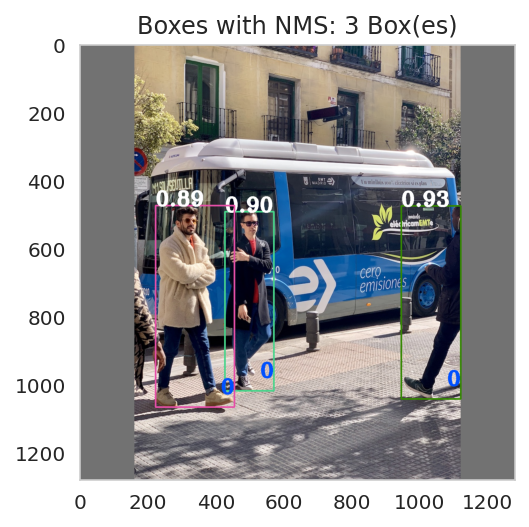

In [17]:
im1 = im0.copy()

for i in nms_xyxyc:
    x1, y1, x2, y2 = i[..., :4].round().astype(np.uint16)
    c = i[..., 4:]
    cv.rectangle(im1, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)
    cv.putText(im1, f"{c[1]:.2f}", (x1,y1) ,thickness=6, color=(255, 255, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
    cv.putText(im1, f"{c[0]:.0f}", (x2-40,y2-40) ,thickness=6, color=(0, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)

plt.title(f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")
plot_single_image(im1)

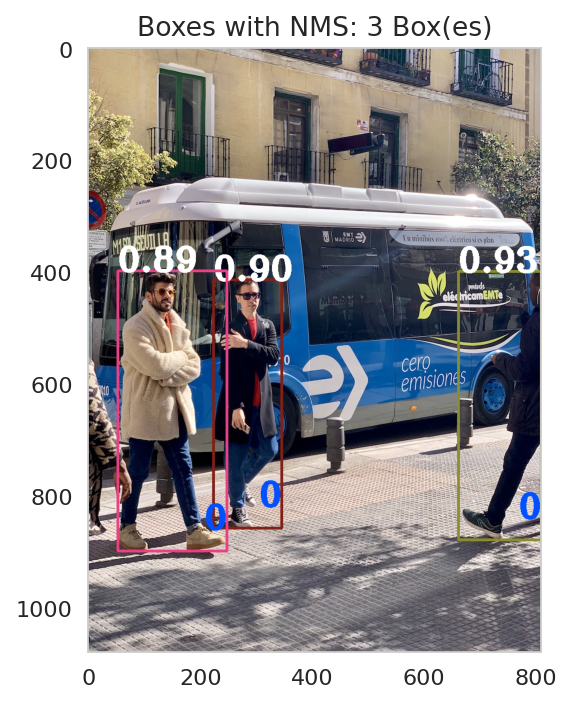

In [18]:
def clip_coords(boxes, shape):
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

# det[:, :4] = scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
def my_scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords

def plot_detect(prediction, batch_inputs, img_source, title=None):
    det = prediction.copy()
    det[:, :4] = my_scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
    img_detect = img_source.copy()
    for i in det:
        x1, y1, x2, y2 = i[..., :4].round().astype(np.uint16)
        c = i[..., 4:]
        cv.rectangle(img_detect, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)
        cv.putText(img_detect, f"{c[1]:.2f}", (x1,y1) ,thickness=6, color=(255, 255, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
        cv.putText(img_detect, f"{c[0]:.0f}", (x2-40,y2-40) ,thickness=6, color=(0, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
    plt.figure(figsize=(5, 5), dpi=80)
    if title is not None:
        plt.title(title)
    plot_single_image(img_detect)

plot_detect(nms_xyxyc, batch_in, img0, title=f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")

In [19]:
print("Single-Class-Detection of 1 Anchor in 1 Head have been already DONE!!!!")

Single-Class-Detection of 1 Anchor in 1 Head have been already DONE!!!!


# Just Continue
